In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
from collections import OrderedDict
from time import time
import os
import glob 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from sklearn.metrics import adjusted_rand_score
from statsmodels.sandbox.stats.multicomp import multipletests 

from snmcseq_utils import plot_tsne_values
from snmcseq_utils import create_logger 
from snmcseq_utils import plot_tsne_labels
from snmcseq_utils import tsne_and_boxplot
from louvain_jaccard import louvain_jaccard

OUTPUT_DIR = '/cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1'

In [2]:
def kmeans(df, n_pc=50, k=30, sub_ncells=None, output_file=False):
    """
    df: (n_bins, n_cells)
    
    """
    ti = time()
    
    df = df.T
    # subsample cells
    if sub_ncells:
        df = df.sample(n=sub_ncells, random_state=1)
    print("Input shape (n_obs, n_features): {}".format(df.shape))
    
    # pca
    pca = PCA(n_components=n_pc).fit(df.values)
    pcs = pca.transform(df.values)
        
    # kmeans
    res = KMeans(n_clusters=k, random_state=1).fit_predict(pcs)
    
    # results
    df_res = pd.DataFrame()
    df_res['sample'] = [cell[:-len('_mcc')] for cell in df.index.values]
    df_res['cluster_ID'] = ['cluster_{}'.format(res_i+1) for res_i in res]
    df_res = df_res.set_index('sample')
    
    # number of clusters
    nclst = np.unique(df_res.cluster_ID.values).shape[0]
    
    # total time
    tf = time()
    
    # summary 
    summary = OrderedDict({'time': tf-ti, 'nclst': nclst, 'n_cells': df.shape[0],
                           'n_pc': n_pc, 'k': k})
    
    # if output 
    if output_file:
        # results
        print('Outputing clustering results to: {}'.format(output_file))
        df_res.to_csv(output_file, sep="\t", na_rep='NA', header=True, index=True)
        # summary
        keys = list(summary.keys()) 
        values = [str(value) for value in list(summary.values())] 
        with open(output_file+'.summary', 'w') as file:
            file.write('\t'.join(keys)+'\n')
            file.write('\t'.join(values)+'\n')
    
    return df_res, summary 

In [3]:
# dataset
f_mcc = '/cndd/fangming/snmcseq_dev/data/binc/binc_mCH_human_combined_100000_summary_nmcc_v3.tsv.MB_v1'
df_mcc = pd.read_table(f_mcc, 
                       index_col=['chr', 'bin'], 
                       dtype={'chr': object}, 
                      )
print(df_mcc.shape)
df_mcc.head()

(26058, 2784)


160729_MB_v1_hs_25yr_MFG_pool_1000_AD008_indexed_mcc  \
chr bin                                                             
1   700000                                            0.444501      
    800000                                            0.455122      
    900000                                            0.364766      
    1000000                                           0.373861      
    1100000                                           0.186150      

             160729_MB_v1_hs_25yr_MFG_pool_1000_AD010_indexed_mcc  \
chr bin                                                             
1   700000                                            0.551815      
    800000                                            0.570488      
    900000                                            0.347003      
    1000000                                           0.442506      
    1100000                                           0.185389      

             160729_MB_v1_hs_25yr_MFG_pool_1001_AD008_indexed_mcc  \
chr bin                                                             
1   700000                                            0.613506      
    800000                                            0.683784      
    900000                                            0.297058      
    1000000                                           0.449216      
    1100000                                           0.195991      

             160729_MB_v1_hs_25yr_MFG_pool_1001_AD010_indexed_mcc  \
chr bin                                                             
1   700000                                            0.527836      
    800000                                            0.390792      
    900000                                            0.285226      
    1000000                                           0.503618      
    1100000                                           0.339465      

             160729_MB_v1_hs_25yr_MFG_pool_1002_AD010_indexed_mcc  \
chr bin                                                             
1   700000                                            0.192012      
    800000                                            0.549240      
    900000                                            0.191181      
    1000000                                           0.437189      
    1100000                                           0.235397      

             160729_MB_v1_hs_25yr_MFG_pool_1003_AD008_indexed_mcc  \
chr bin                                                             
1   700000                                            0.401290      
    800000                                            0.445831      
    900000                                            0.499128      
    1000000                                           0.447847      
    1100000                                           0.195963      

             160729_MB_v1_hs_25yr_MFG_pool_1003_AD010_indexed_mcc  \
chr bin                                                             
1   700000                                            0.427596      
    800000                                            0.712364      
    900000                                            0.256421      
    1000000                                           0.624226      
    1100000                                           0.364786      

             160729_MB_v1_hs_25yr_MFG_pool_1004_AD008_indexed_mcc  \
chr bin                                                             
1   700000                                            0.955501      
    800000                                            0.648765      
    900000                                            0.254021      
    1000000                                           0.399513      
    1100000                                           0.362107      

             160729_MB_v1_hs_25yr_MFG_pool_1004_AD010_indexed_mcc  \
chr bin                                                             
1  

In [4]:
# # include only files from hv1

# f_meta = '/cndd/fangming/snmcseq_dev/data/metadata/metadata_human_combined_updated.tsv'
# df_meta = pd.read_table(f_meta, index_col='Sample')
# df_mcc2 = df_mcc[df_meta[df_meta.Biosample=='MB_v1'].index.values+'_mcc']

# df_mcc2.to_csv(f_mcc+'.MB_v1', sep='\t', header=True, index=True)

In [5]:
# eyeballing tSNE clustering results
f_tsne = '/cndd/fangming/snmcseq_dev/data/tsne/tsne_perp30_binc_mCH_human_combined_100000_summary_nmcc_v3.tsv'
f_tsne = '/cndd/fangming/snmcseq_dev/data/cluster/cluster_MB_v1/cluster_MB_v1.tsv'
df_tsne = pd.read_table(f_tsne, index_col='sample').sort_index()
df_tsne = df_tsne[~df_tsne.tsne_x.isnull()]
df_tsne.head()

cell_type    tsne_x    tsne_y
sample                                                                        
160729_MB_v1_hs_25yr_MFG_pool_1000_AD008_indexed    hSst-2  18.68820  -4.40599
160729_MB_v1_hs_25yr_MFG_pool_1000_AD010_indexed     hPv-1  13.09170  -4.69515
160729_MB_v1_hs_25yr_MFG_pool_1001_AD008_indexed     hPv-1  12.39970  -5.21976
160729_MB_v1_hs_25yr_MFG_pool_1001_AD010_indexed     hL2/3 -12.17260  10.98450
160729_MB_v1_hs_25yr_MFG_pool_1002_AD010_indexed     hL6-3   1.71175  -6.13753

In [6]:
# louvain
df_res_louvain, summary = louvain_jaccard(df_mcc, n_pc=50, k=30, sub_ncells=1000,
                                          output_file=os.path.join(OUTPUT_DIR, 'test_louvain.tsv'))
print(summary)
df_res_louvain.head()

Input shape (n_obs, n_features): (1000, 26058)
Outputing clustering results to: /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1/test_louvain.tsv
Done with clustering!
OrderedDict([('time', 8.554316997528076), ('time_clst', 0.17840576171875), ('n_cells', 1000), ('k', 30), ('nclst', 16), ('n_pc', 50)])


cluster_ID
sample                                                     
160729_MB_v1_hs_25yr_MFG_pool_871_AD006_indexed   cluster_8
160729_MB_v1_hs_25yr_MFG_pool_1034_AD002_indexed  cluster_2
160729_MB_v1_hs_25yr_MFG_pool_258_AD010_indexed   cluster_7
160729_MB_v1_hs_25yr_MFG_pool_1014_AD006_indexed  cluster_7
160729_MB_v1_hs_25yr_MFG_pool_37_AD010_indexed    cluster_1

In [7]:
# k_means

n_pc = 50
nclst = summary['nclst']  

df_res_kmeans, summary = kmeans(df_mcc, n_pc=n_pc, k=nclst, sub_ncells=1000, 
                                output_file=os.path.join(OUTPUT_DIR, 'test_kmeans.tsv'))
print(summary)

df_res_kmeans.head()

Input shape (n_obs, n_features): (1000, 26058)
Outputing clustering results to: /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1/test_kmeans.tsv
OrderedDict([('time', 8.320890188217163), ('n_pc', 50), ('k', 16), ('n_cells', 1000), ('nclst', 16)])


cluster_ID
sample                                                      
160729_MB_v1_hs_25yr_MFG_pool_871_AD006_indexed    cluster_9
160729_MB_v1_hs_25yr_MFG_pool_1034_AD002_indexed  cluster_10
160729_MB_v1_hs_25yr_MFG_pool_258_AD010_indexed    cluster_6
160729_MB_v1_hs_25yr_MFG_pool_1014_AD006_indexed   cluster_6
160729_MB_v1_hs_25yr_MFG_pool_37_AD010_indexed     cluster_2

In [8]:
# random labeling
df_res_random = pd.DataFrame(index=df_res_louvain.index)
df_res_random['cluster_ID'] = ['cluster_{}'.format(i) 
                               for i in np.random.randint(1, nclst+1, size=(df_res_random.index.shape[0],))]
df_res_random.head()

cluster_ID
sample                                                      
160729_MB_v1_hs_25yr_MFG_pool_871_AD006_indexed    cluster_5
160729_MB_v1_hs_25yr_MFG_pool_1034_AD002_indexed   cluster_6
160729_MB_v1_hs_25yr_MFG_pool_258_AD010_indexed   cluster_15
160729_MB_v1_hs_25yr_MFG_pool_1014_AD006_indexed   cluster_4
160729_MB_v1_hs_25yr_MFG_pool_37_AD010_indexed     cluster_1

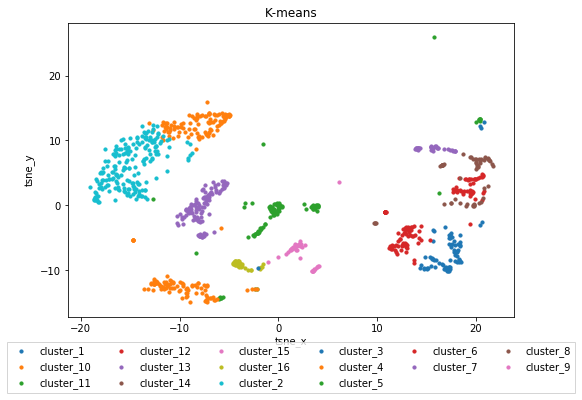

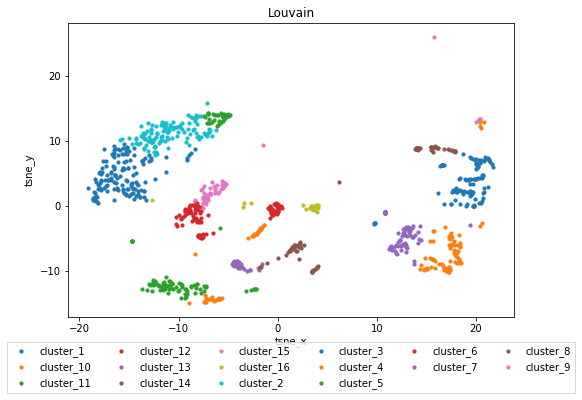

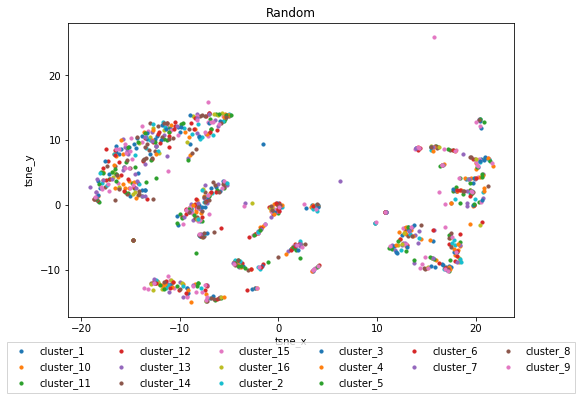

In [9]:
df_plot = pd.merge(df_tsne, df_res_kmeans, left_index=True, right_index=True)
# df_plot = df_plot[~df_plot.tsne_x.isnull()]
plot_tsne_labels(df_plot, tc='cluster_ID', legend_mode=1, s=10, title='K-means')
df_plot = pd.merge(df_tsne, df_res_louvain, left_index=True, right_index=True)
# df_plot = df_plot[~df_plot.tsne_x.isnull()]
plot_tsne_labels(df_plot, tc='cluster_ID', legend_mode=1, s=10, title='Louvain')
df_plot = pd.merge(df_tsne, df_res_random, left_index=True, right_index=True)
# df_plot = df_plot[~df_plot.tsne_x.isnull()]
plot_tsne_labels(df_plot, tc='cluster_ID', legend_mode=1, s=10, title='Random')

In [10]:
# adjusted_rand_score(df_clannot1.cluster_annotation, df_clannot2.cluster_annotation)

df_res_kmeans = df_res_kmeans.sort_index()
df_res_louvain = df_res_louvain.sort_index()
df_res_random = df_res_random.sort_index()

s1, s1_ind = pd.factorize(df_res_kmeans.cluster_ID)
s2, s2_ind = pd.factorize(df_res_louvain.cluster_ID)
s3, s3_ind = pd.factorize(df_res_random.cluster_ID)
res = adjusted_rand_score(s1, s2)
print(res)
res = adjusted_rand_score(s1, s3)
print(res)
res = adjusted_rand_score(s2, s3)
print(res)

0.682229889643
-0.000890790878029
0.000878979450279


In [11]:
# annotation

In [20]:
for k in np.arange(6, 10, 1):
    # louvain
    n_pc = 50
    df_res_louvain, summary_louvain = louvain_jaccard(df_mcc, n_pc=n_pc, k=k, 
                                              output_file=os.path.join(OUTPUT_DIR, 'test_louvain_{}p.tsv'.format(k)))
    print(summary_louvain)

#     # k_means (matched k_means k)
#     n_pc = 50
#     nclst = summary_louvain['nclst']  
#     df_res_kmeans, summary_kmeans = kmeans(df_mcc, n_pc=n_pc, k=nclst,  
#                                     output_file=os.path.join(OUTPUT_DIR, 'test_kmeans_{}p.tsv'.format(k)))
#     print(summary_kmeans)

Input shape (n_obs, n_features): (2784, 26058)
Outputing clustering results to: /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1/test_louvain_6p.tsv
Done with clustering!
OrderedDict([('time', 9.998249292373657), ('time_clst', 0.6840527057647705), ('n_cells', 2784), ('k', 6), ('nclst', 65), ('n_pc', 50)])
Input shape (n_obs, n_features): (2784, 26058)
Outputing clustering results to: /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1/test_louvain_7p.tsv
Done with clustering!
OrderedDict([('time', 14.9259192943573), ('time_clst', 0.6740281581878662), ('n_cells', 2784), ('k', 7), ('nclst', 52), ('n_pc', 50)])
Input shape (n_obs, n_features): (2784, 26058)
Outputing clustering results to: /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1/test_louvain_8p.tsv
Done with clustering!
OrderedDict([('time', 18.43215799331665), ('time_clst', 0.688819169998169), ('n_cells', 2784), ('k', 8), ('nclst', 49), ('n_pc', 50)])
Input shape (n_obs, n_features): (2784, 26058)
O

In [115]:
# get info from files and look at ari similarity

files = (glob.glob(os.path.join(OUTPUT_DIR, 'test_*p.tsv.summary')) + 
        glob.glob(os.path.join(OUTPUT_DIR, 'test_kmeans_*k.tsv.summary')))
info_list = []
nclsts_louvain = []
nclsts_kmeans = []
nclsts_backspin = []
for file in files:
    f = pd.read_table(file)
    method = os.path.basename(file).split('_')[1]
    if method == 'louvain':
        nclst = f['nclst'].values[0]
        if nclst not in nclsts_louvain:
            nclsts_louvain.append(nclst)
            info = {'method': method, 
                    'nclst': f['nclst'].values[0],
                    'ncell': f['n_cells'].values[0],
                    'time': f['time'].values[0],
                    'time_clst': f['time_clst'].values[0],
                    'k': f['k'].values[0],
                    'file': file[:-len('.summary')]
                   }
            info_list.append(info)
    elif method == 'kmeans':
        nclst = f['nclst'].values[0]
        if nclst not in nclsts_kmeans:
            nclsts_kmeans.append(nclst)
            info = {'method': method, 
                    'nclst': f['nclst'].values[0],
                    'ncell': f['n_cells'].values[0],
                    'time': f['time'].values[0],
                    'time_clst': np.nan, 
                    'k': f['k'].values[0],
                    'file': file[:-len('.summary')]
                   }
            info_list.append(info)
    elif method == 'backspin':
        nclst = f['nclst'].values[0]
        if nclst not in nclsts_backspin:
            nclsts_backspin.append(nclst)
            info = {'method': method, 
                    'nclst': f['nclst'].values[0],
                    'ncell': f['n_cells'].values[0],
                    'time': f['time'].values[0],
                    'time_clst': np.nan, 
                    'k': f['var_increase_ratio'].values[0],
                    'file': file[:-len('.summary')]
                   }
            info_list.append(info)

df_info = pd.DataFrame(info_list)
df_info_pivot = pd.pivot_table(df_info, values=['k'], columns='method', index='nclst')
df_info_pivot

k               
method backspin kmeans louvain
nclst                         
3           NaN    3.0  1000.0
5           NaN    5.0   500.0
7           NaN    7.0   350.0
8          1.00    8.0   250.0
9           NaN    9.0   200.0
12         0.80   12.0     NaN
14         0.70   14.0   100.0
17         0.63   17.0     NaN
20          NaN   20.0    50.0
22          NaN   22.0    40.0
23         0.50   23.0     NaN
24         0.45   24.0     NaN
25          NaN   25.0    35.0
26         0.40   26.0     NaN
28          NaN   28.0    25.0
30          NaN   30.0    20.0
31         0.35   31.0     NaN
34         0.30   34.0    15.0
41         0.25   41.0    10.0
43         0.20   43.0     9.0
49          NaN   49.0     8.0
51         0.15   51.0     NaN
52          NaN   52.0     7.0
53         0.12   53.0     NaN
57         0.10   57.0     NaN
65          NaN   65.0     6.0
76          NaN   76.0     5.0
81         0.05   81.0     NaN

In [116]:
files = (glob.glob(os.path.join(OUTPUT_DIR, 'test_*p.tsv.summary')) + 
        glob.glob(os.path.join(OUTPUT_DIR, 'test_kmeans_*k.tsv.summary')))
info_list = []
nclsts_louvain = []
nclsts_kmeans = []
nclsts_backspin = []
for file in files:
    # only look at those that have enough coverage
    if os.path.isfile(file[:-len('.summary')]+'.annot'):
        f = pd.read_table(file)
        method = os.path.basename(file).split('_')[1]
        if method == 'louvain':
            nclst = f['nclst'].values[0]
            if nclst not in nclsts_louvain:
                nclsts_louvain.append(nclst)
                info = {'method': method, 
                        'nclst': f['nclst'].values[0],
                        'ncell': f['n_cells'].values[0],
                        'time': f['time'].values[0],
                        'time_clst': f['time_clst'].values[0],
                        'k': f['k'].values[0],
                        'file': file[:-len('.summary')]
                       }
                info_list.append(info)
        elif method == 'kmeans':
            nclst = f['nclst'].values[0]
            if nclst not in nclsts_kmeans:
                nclsts_kmeans.append(nclst)
                info = {'method': method, 
                        'nclst': f['nclst'].values[0],
                        'ncell': f['n_cells'].values[0],
                        'time': f['time'].values[0],
                        'time_clst': np.nan, 
                        'k': f['k'].values[0],
                        'file': file[:-len('.summary')]
                       }
                info_list.append(info)
        elif method == 'backspin':
            nclst = f['nclst'].values[0]
            if nclst not in nclsts_backspin:
                nclsts_backspin.append(nclst)
                info = {'method': method, 
                        'nclst': f['nclst'].values[0],
                        'ncell': f['n_cells'].values[0],
                        'time': f['time'].values[0],
                        'time_clst': np.nan, 
                        'k': f['var_increase_ratio'].values[0],
                        'file': file[:-len('.summary')]
                       }
                info_list.append(info)

df_info_2 = pd.DataFrame(info_list)
df_info_pivot_2 = pd.pivot_table(df_info_2, values=['k'], columns='method', index='nclst')
print(df_info_pivot_2.shape)

df_info_pivot_2

(28, 3)


k               
method backspin kmeans louvain
nclst                         
3           NaN    3.0  1000.0
5           NaN    5.0   500.0
7           NaN    7.0   350.0
8          1.00    8.0   250.0
9           NaN    9.0   200.0
12         0.80   12.0     NaN
14         0.70   14.0   100.0
17         0.63   17.0     NaN
20          NaN   20.0    50.0
22          NaN   22.0    40.0
23         0.50   23.0     NaN
24         0.45   24.0     NaN
25          NaN   25.0    35.0
26         0.40   26.0     NaN
28          NaN   28.0    25.0
30          NaN   30.0    20.0
31         0.35   31.0     NaN
34         0.30   34.0    15.0
41         0.25   41.0    10.0
43         0.20   43.0     9.0
49          NaN   49.0     8.0
51         0.15   51.0     NaN
52          NaN   52.0     7.0
53         0.12   53.0     NaN
57         0.10   57.0     NaN
65          NaN   65.0     6.0
76          NaN   76.0     5.0
81         0.05   81.0     NaN

In [10]:
# cond1 = ~df_info_pivot[('k', 'backspin')].isnull()
# cond2 = ~df_info_pivot[('k', 'louvain')].isnull()
cond3 = df_info_pivot[('k', 'kmeans')].isnull()
cond = cond3
ks = df_info_pivot[cond].index.values
print(ks.shape)

# run kmeans for all k:
for k in ks:
    n_pc = 50
    k = k  
    df_res_kmeans, summary_kmeans = kmeans(df_mcc, n_pc=n_pc, k=k,  
                                    output_file=os.path.join(OUTPUT_DIR, 'test_kmeans_{}p.tsv'.format(k)))
    print(summary_kmeans)

(23,)
Input shape (n_obs, n_features): (2784, 26058)
Outputing clustering results to: /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1/test_kmeans_3p.tsv
OrderedDict([('n_cells', 2784), ('n_pc', 50), ('nclst', 3), ('k', 3), ('time', 7.353082895278931)])
Input shape (n_obs, n_features): (2784, 26058)
Outputing clustering results to: /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1/test_kmeans_5p.tsv
OrderedDict([('n_cells', 2784), ('n_pc', 50), ('nclst', 5), ('k', 5), ('time', 7.337296962738037)])
Input shape (n_obs, n_features): (2784, 26058)
Outputing clustering results to: /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1/test_kmeans_7p.tsv
OrderedDict([('n_cells', 2784), ('n_pc', 50), ('nclst', 7), ('k', 7), ('time', 7.548857927322388)])
Input shape (n_obs, n_features): (2784, 26058)
Outputing clustering results to: /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1/test_kmeans_9p.tsv
OrderedDict([('n_cells', 2784), ('n_pc', 50), ('nclst', 9)

In [13]:
def ars(array1, array2):
    """
    2 array are matched
    """
    s1, s1_ind = pd.factorize(array1)
    s2, s2_ind = pd.factorize(array2)
    res = adjusted_rand_score(s1, s2)
    return res


In [117]:
# take paired results of louvain and kmeans

df_info_louvain = df_info[df_info.method=='louvain']
df_info_kmeans = df_info[df_info.method=='kmeans']
df_info_backspin = df_info[df_info.method=='backspin']

df_comb1 = pd.merge(df_info_louvain, df_info_kmeans, left_on='nclst', right_on='nclst', sort='True')
df_comb2 = pd.merge(df_info_backspin, df_info_kmeans, left_on='nclst', right_on='nclst', sort='True')
df_comb3 = pd.merge(df_info_louvain, df_info_backspin, left_on='nclst', right_on='nclst', sort='True')

res_list = []
nclsts = []
for i, row in df_comb1.iterrows():
    nclsts.append(row.nclst)
    df1 = pd.read_table(row.file_x, index_col='sample').sort_index()
    df2 = pd.read_table(row.file_y, index_col='sample').sort_index()
    assert df1.index.tolist() == df2.index.tolist()
    
    res = ars(df1.cluster_ID, df2.cluster_ID)
    res_list.append(res)
    
df_res1 = pd.DataFrame()
df_res1['nclst'] = nclsts
df_res1['ari'] = res_list

res_list = []
nclsts = []
for i, row in df_comb2.iterrows():
    nclsts.append(row.nclst)
    df1 = pd.read_table(row.file_x, index_col='sample').sort_index()
    df2 = pd.read_table(row.file_y, index_col='sample').sort_index()
    assert df1.index.tolist() == df2.index.tolist()
    
    res = ars(df1.cluster_ID, df2.cluster_ID)
    res_list.append(res)
    
df_res2 = pd.DataFrame()
df_res2['nclst'] = nclsts
df_res2['ari'] = res_list

res_list = []
nclsts = []
for i, row in df_comb3.iterrows():
    nclsts.append(row.nclst)
    df1 = pd.read_table(row.file_x, index_col='sample').sort_index()
    df2 = pd.read_table(row.file_y, index_col='sample').sort_index()
    assert df1.index.tolist() == df2.index.tolist()
    
    res = ars(df1.cluster_ID, df2.cluster_ID)
    res_list.append(res)
    
df_res3 = pd.DataFrame()
df_res3['nclst'] = nclsts
df_res3['ari'] = res_list

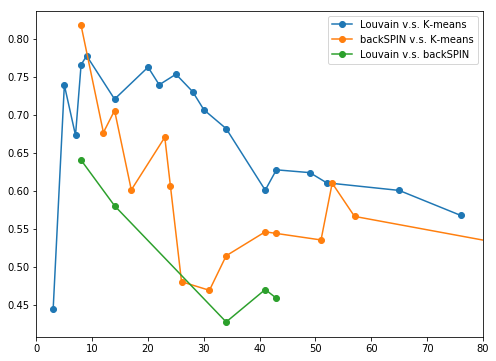

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_res1.nclst, df_res1.ari, '-o', label='Louvain v.s. K-means')
ax.plot(df_res2.nclst, df_res2.ari, '-o', label='backSPIN v.s. K-means')
ax.plot(df_res3.nclst, df_res3.ari, '-o', label='Louvain v.s. backSPIN')
# ax.set_xticks(df_res2.nclst)
# ax.set_xticklabels(df_res.nclst, rotation=90)
ax.set_xlim([0, 80])
ax.legend()
plt.show()

In [118]:
# take paired results of louvain and kmeans

df_info_louvain = df_info_2[df_info_2.method=='louvain']
df_info_kmeans = df_info_2[df_info_2.method=='kmeans']
df_info_backspin = df_info_2[df_info_2.method=='backspin']

df_comb1 = pd.merge(df_info_louvain, df_info_kmeans, left_on='nclst', right_on='nclst', sort='True')
df_comb2 = pd.merge(df_info_backspin, df_info_kmeans, left_on='nclst', right_on='nclst', sort='True')
df_comb3 = pd.merge(df_info_louvain, df_info_backspin, left_on='nclst', right_on='nclst', sort='True')

res_list = []
nclsts = []
for i, row in df_comb1.iterrows():
    nclsts.append(row.nclst)
    df1 = pd.read_table(row.file_x, index_col='sample')
    df1_annot = pd.read_table(row.file_x+'.annot', index_col='cluster_ID')
    df1 = pd.merge(df1, df1_annot, left_on='cluster_ID', right_index=True).sort_index()
    
    df2 = pd.read_table(row.file_y, index_col='sample')
    df2_annot = pd.read_table(row.file_y+'.annot', index_col='cluster_ID')
    df2 = pd.merge(df2, df2_annot, left_on='cluster_ID', right_index=True).sort_index()
    assert df1.index.tolist() == df2.index.tolist()
    
    res = ars(df1.cluster_annotation, df2.cluster_annotation)
    res_list.append(res)
    
df_res11 = pd.DataFrame()
df_res11['nclst'] = nclsts
df_res11['ari'] = res_list

res_list = []
nclsts = []
for i, row in df_comb2.iterrows():
    nclsts.append(row.nclst)
    df1 = pd.read_table(row.file_x, index_col='sample')
    df1_annot = pd.read_table(row.file_x+'.annot', index_col='cluster_ID')
    df1 = pd.merge(df1, df1_annot, left_on='cluster_ID', right_index=True).sort_index()
    
    df2 = pd.read_table(row.file_y, index_col='sample')
    df2_annot = pd.read_table(row.file_y+'.annot', index_col='cluster_ID')
    df2 = pd.merge(df2, df2_annot, left_on='cluster_ID', right_index=True).sort_index()
    assert df1.index.tolist() == df2.index.tolist()
    
    res = ars(df1.cluster_annotation, df2.cluster_annotation)
    res_list.append(res)
    
df_res22 = pd.DataFrame()
df_res22['nclst'] = nclsts
df_res22['ari'] = res_list

res_list = []
nclsts = []
for i, row in df_comb3.iterrows():
    nclsts.append(row.nclst)
    df1 = pd.read_table(row.file_x, index_col='sample')
    df1_annot = pd.read_table(row.file_x+'.annot', index_col='cluster_ID')
    df1 = pd.merge(df1, df1_annot, left_on='cluster_ID', right_index=True).sort_index()
    
    df2 = pd.read_table(row.file_y, index_col='sample')
    df2_annot = pd.read_table(row.file_y+'.annot', index_col='cluster_ID')
    df2 = pd.merge(df2, df2_annot, left_on='cluster_ID', right_index=True).sort_index()
    assert df1.index.tolist() == df2.index.tolist()
    
    res = ars(df1.cluster_annotation, df2.cluster_annotation)
    res_list.append(res)
    
df_res33 = pd.DataFrame()
df_res33['nclst'] = nclsts
df_res33['ari'] = res_list

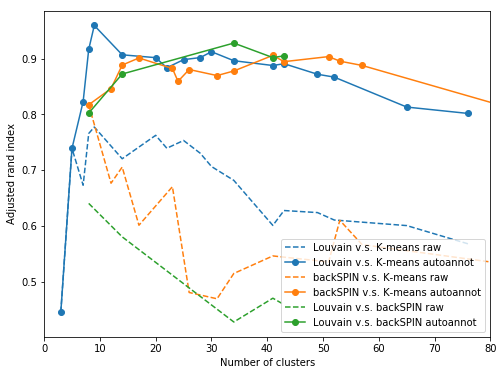

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_res1.nclst, df_res1.ari, '--', label='Louvain v.s. K-means raw', color='C0')
ax.plot(df_res11.nclst, df_res11.ari, '-o', label='Louvain v.s. K-means autoannot', color='C0')
ax.plot(df_res2.nclst, df_res2.ari, '--', label='backSPIN v.s. K-means raw', color='C1')
ax.plot(df_res22.nclst, df_res22.ari, '-o', label='backSPIN v.s. K-means autoannot', color='C1')
ax.plot(df_res3.nclst, df_res3.ari, '--', label='Louvain v.s. backSPIN raw', color='C2')
ax.plot(df_res33.nclst, df_res33.ari, '-o', label='Louvain v.s. backSPIN autoannot', color='C2')
# ax.set_xticks(df_res2.nclst)
# ax.set_xticklabels(df_res.nclst, rotation=90)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Adjusted rand index')
ax.set_xlim([0, 80])
ax.legend(loc='lower right')
plt.show()

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_3_clusters.pdf


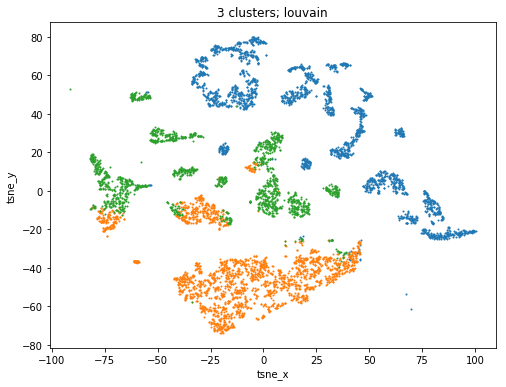

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_3_clusters.pdf


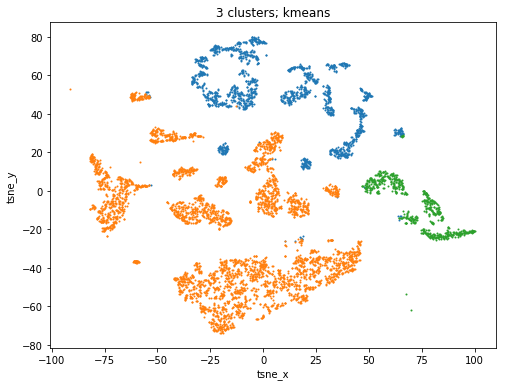

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_4_clusters.pdf


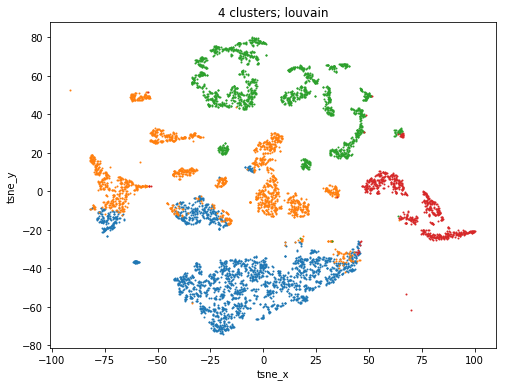

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_4_clusters.pdf


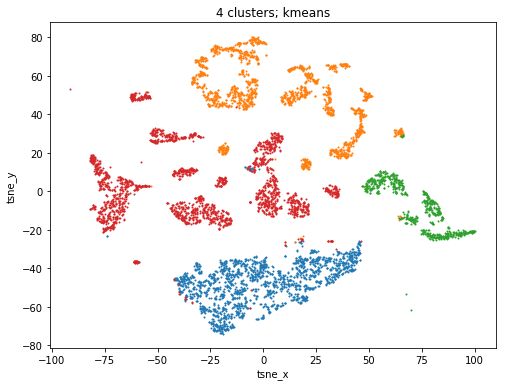

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_5_clusters.pdf


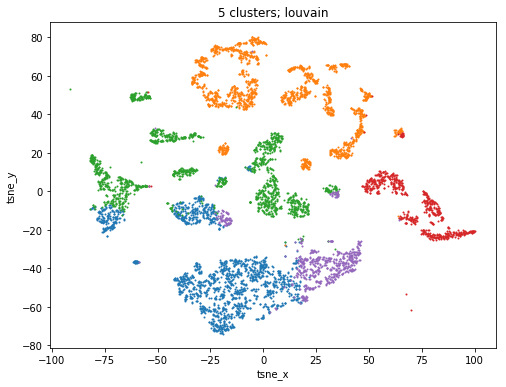

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_5_clusters.pdf


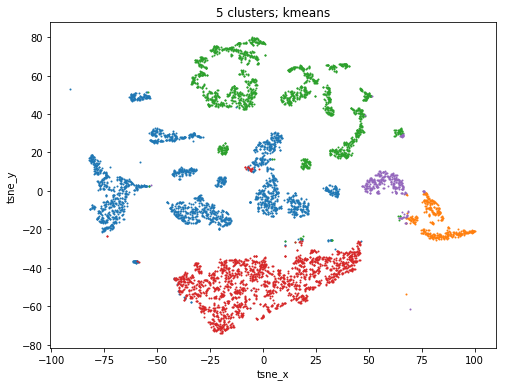

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_6_clusters.pdf


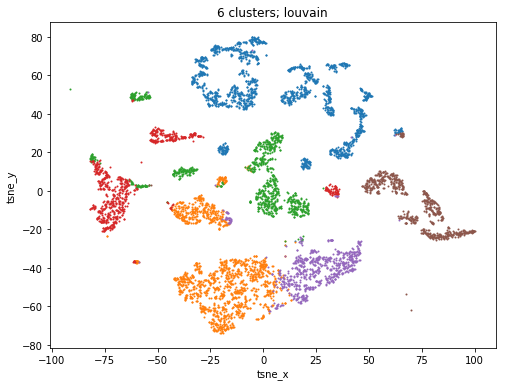

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_6_clusters.pdf


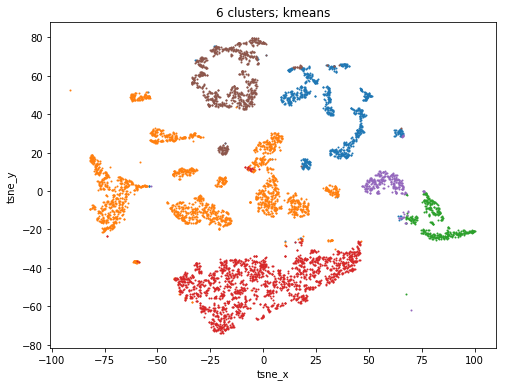

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_8_clusters.pdf


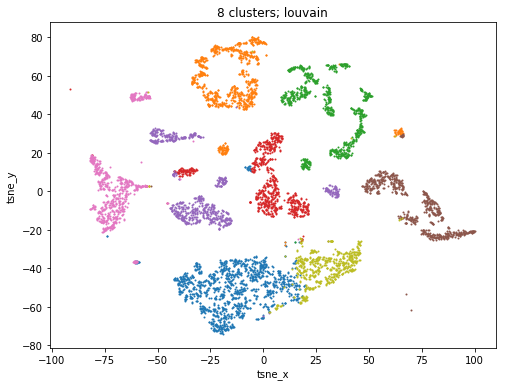

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_8_clusters.pdf


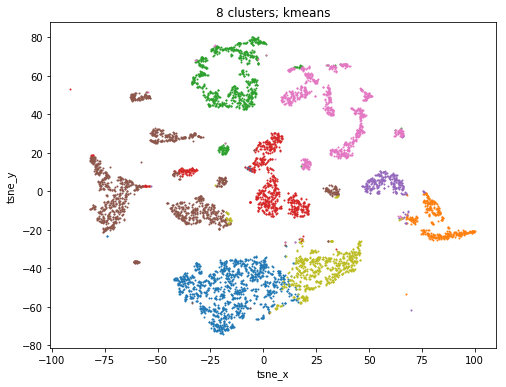

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_10_clusters.pdf


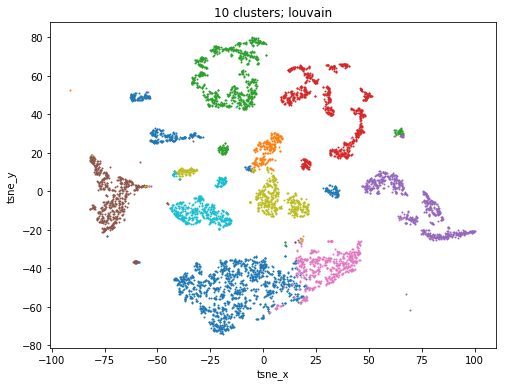

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_10_clusters.pdf


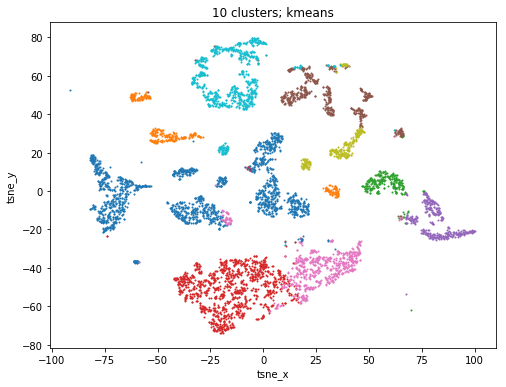

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_11_clusters.pdf


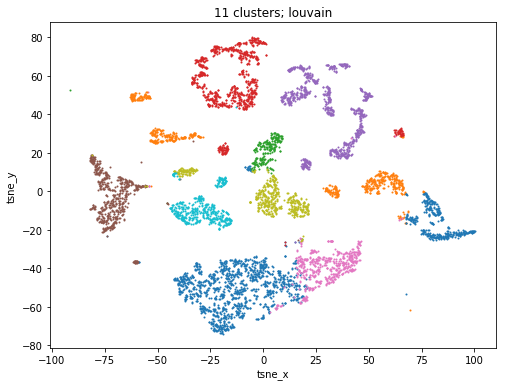

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_11_clusters.pdf


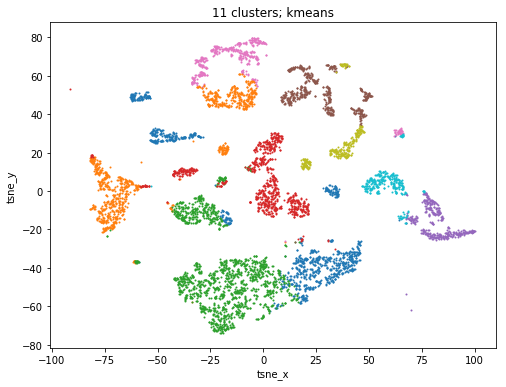

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_12_clusters.pdf


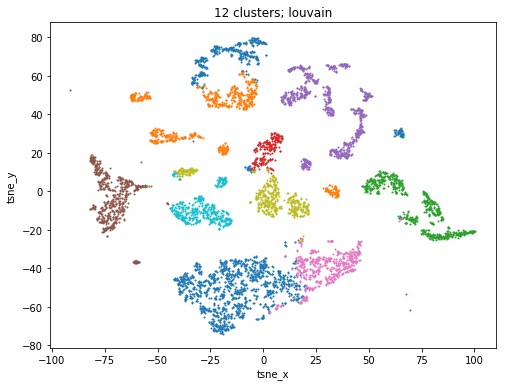

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_12_clusters.pdf


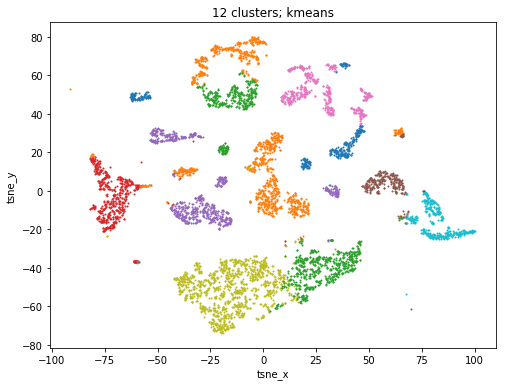

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_13_clusters.pdf


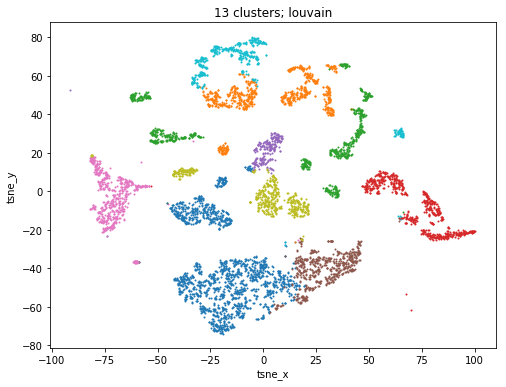

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_13_clusters.pdf


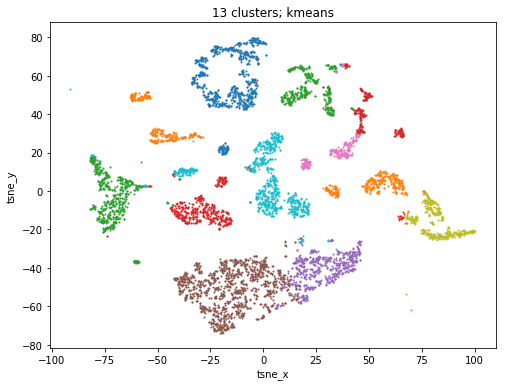

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_15_clusters.pdf


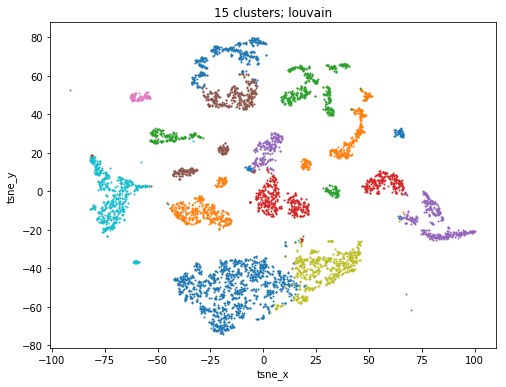

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_15_clusters.pdf


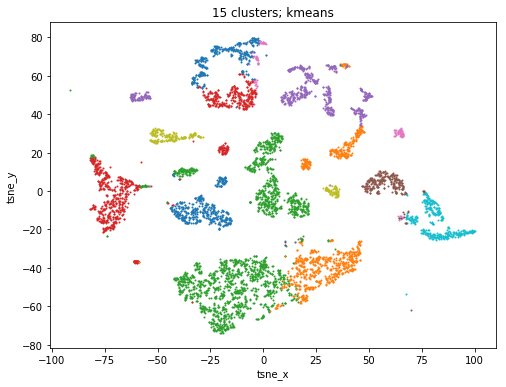

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_3_clusters.pdf


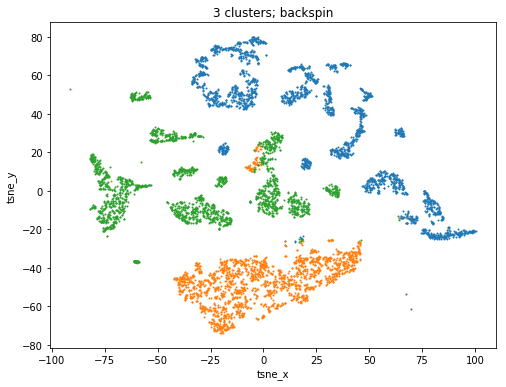

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_3_clusters.pdf


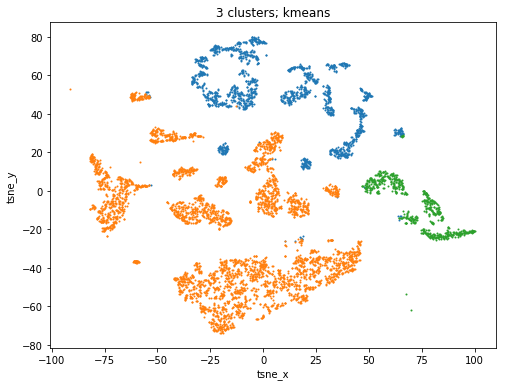

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_9_clusters.pdf


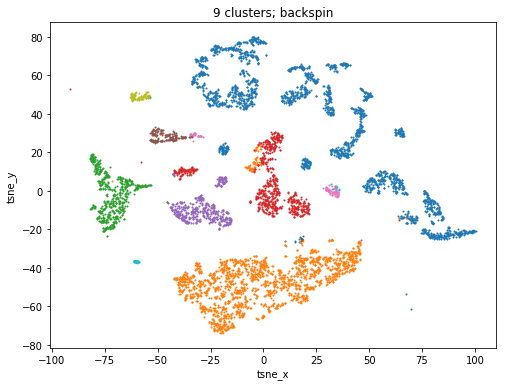

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_9_clusters.pdf


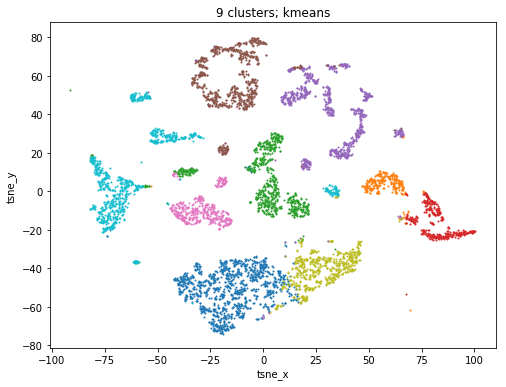

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_10_clusters.pdf


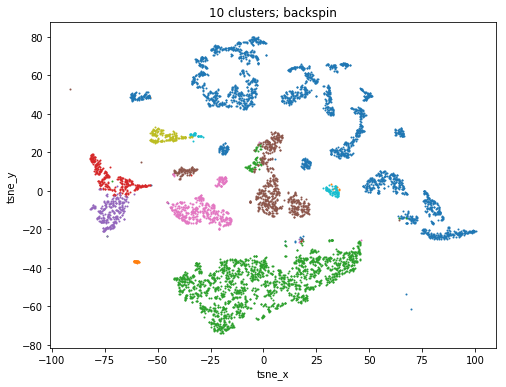

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_10_clusters.pdf


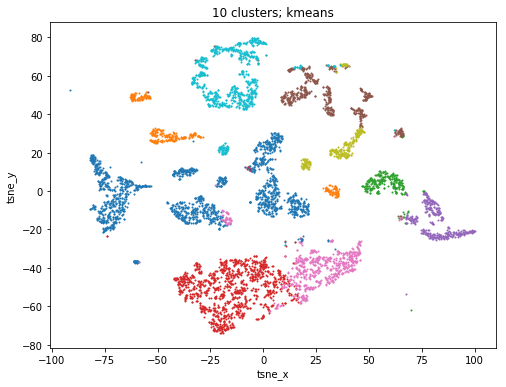

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_13_clusters.pdf


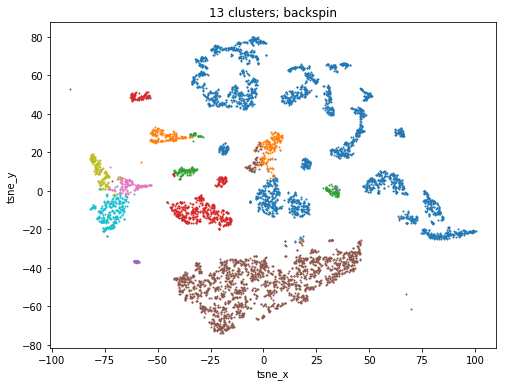

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_13_clusters.pdf


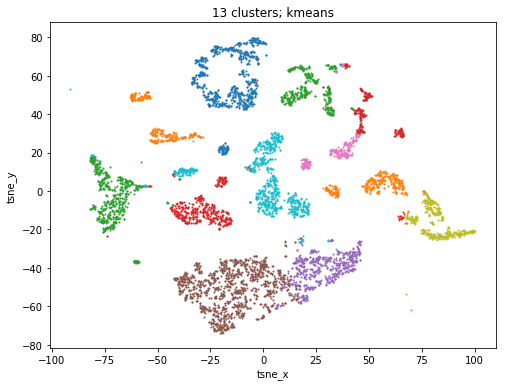

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_21_clusters.pdf


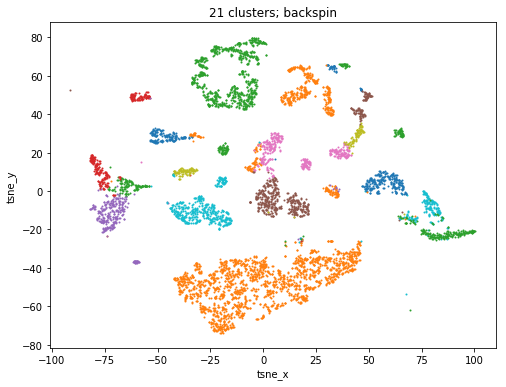

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_21_clusters.pdf


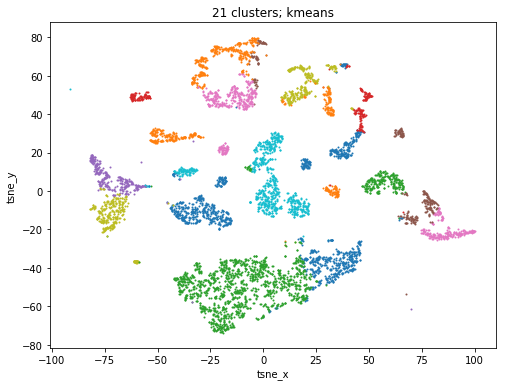

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_22_clusters.pdf


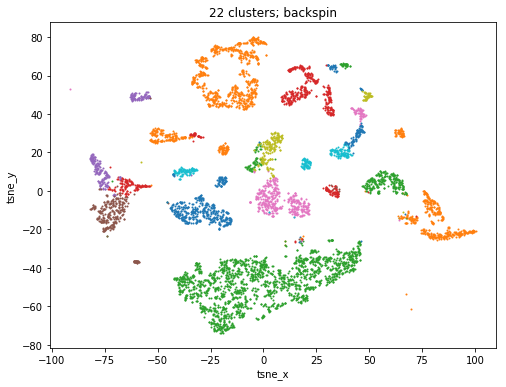

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_22_clusters.pdf


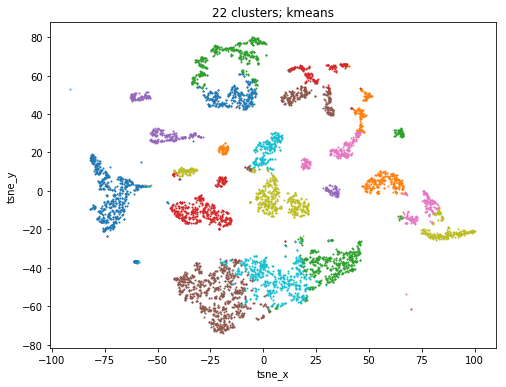

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_23_clusters.pdf


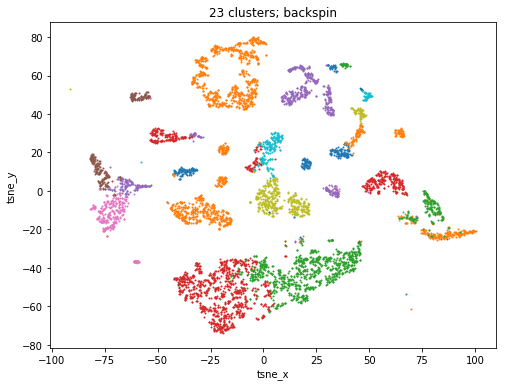

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_23_clusters.pdf


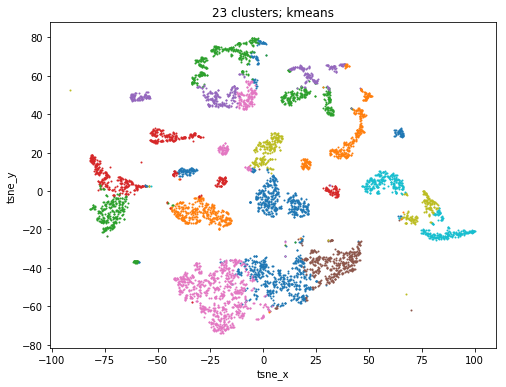

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_27_clusters.pdf


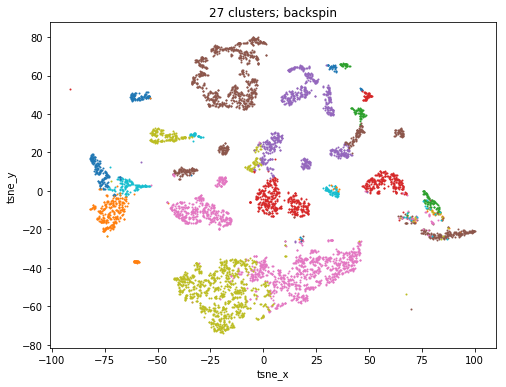

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/kmeans_27_clusters.pdf


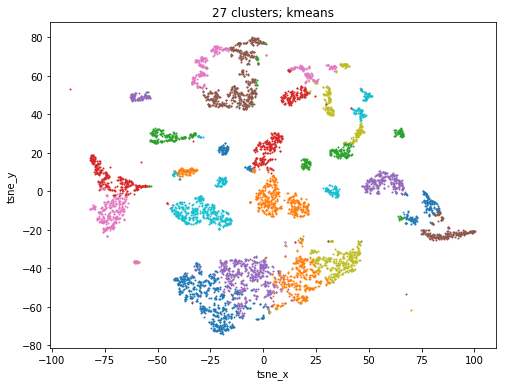

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_3_clusters.pdf


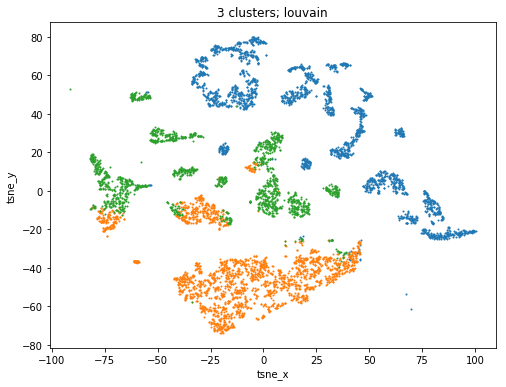

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_3_clusters.pdf


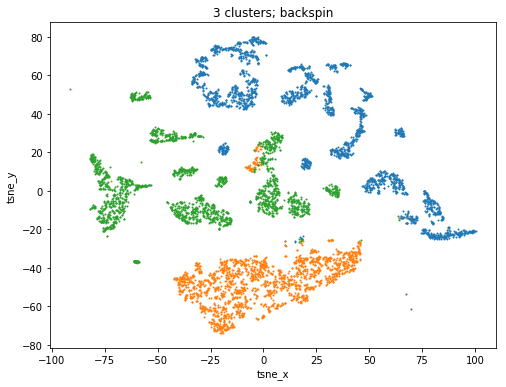

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_10_clusters.pdf


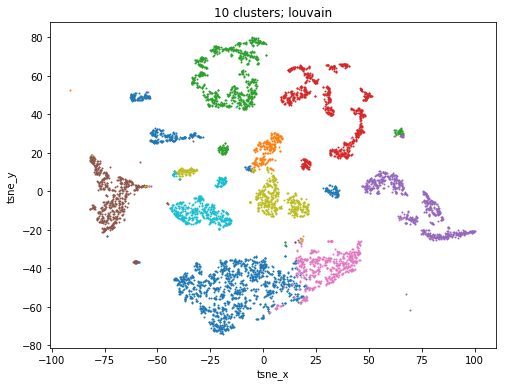

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_10_clusters.pdf


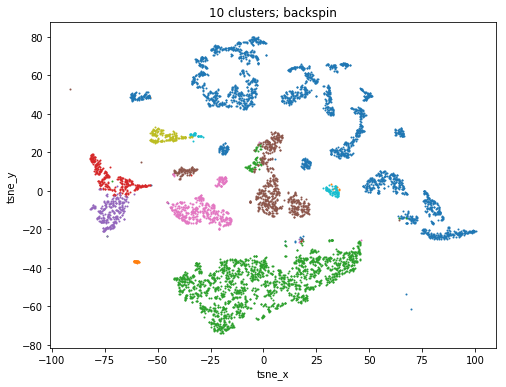

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_13_clusters.pdf


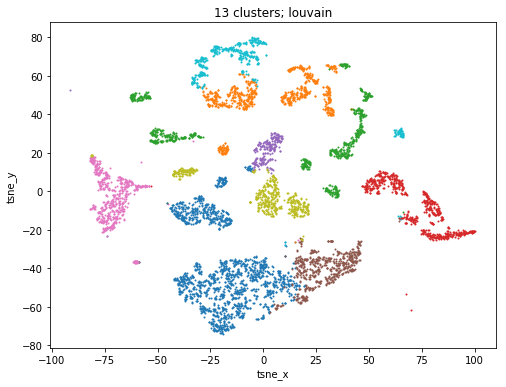

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_13_clusters.pdf


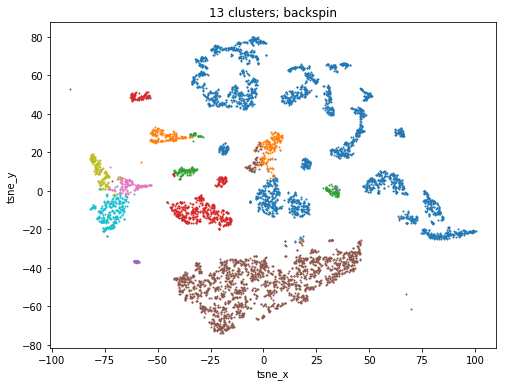

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_22_clusters.pdf


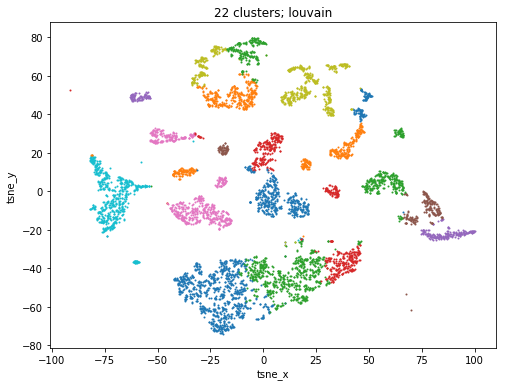

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_22_clusters.pdf


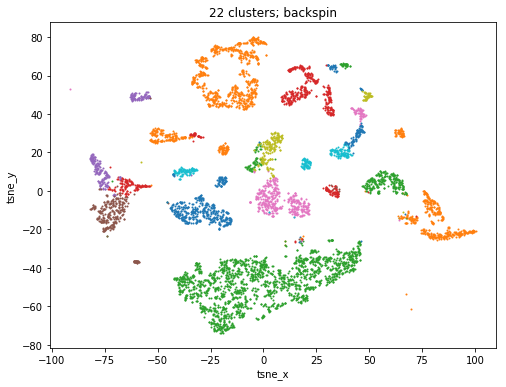

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_27_clusters.pdf


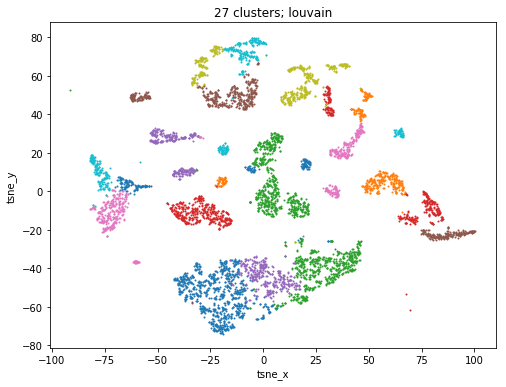

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_27_clusters.pdf


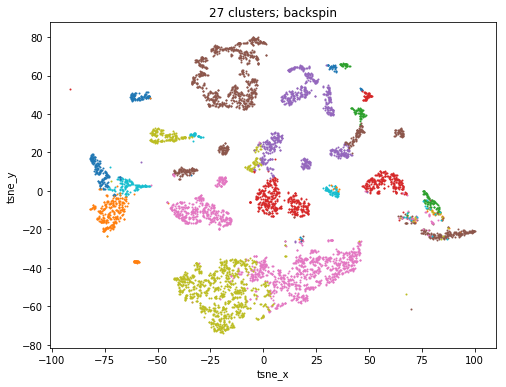

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/louvain_35_clusters.pdf


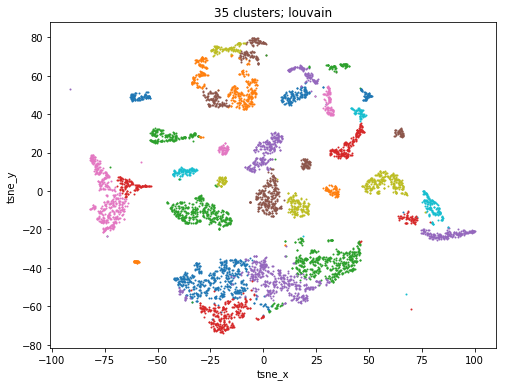

Saved to /cndd/fangming/snmcseq_dev/data/cluster/test_clusters/MB_v1_MB_EA_MB_EB/figures/backspin_35_clusters.pdf


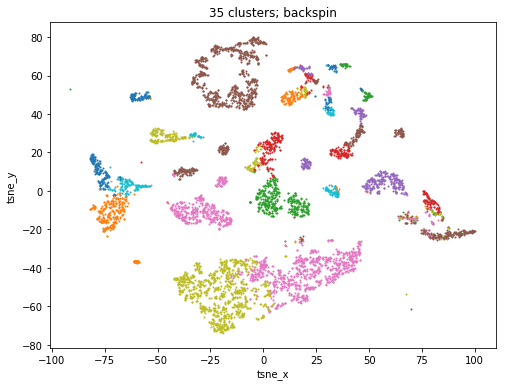

In [144]:
# # some examples from tSNE

for i, row in df_comb1.iterrows():
    if row.nclst < 20: 
        df = pd.read_table(row.file_x, index_col='sample')
        df_plot = pd.merge(df_tsne, df, left_index=True, right_index=True)
        output = os.path.join(OUTPUT_DIR, 'figures/{}_{}_clusters.pdf'.format(row.method_x, row.nclst))
        plot_tsne_labels(df_plot, tc='cluster_ID', 
                         title='{} clusters; {}'.format(row.nclst, row.method_x), 
                         output=output,
                         legend_mode=-1
                        )

        df = pd.read_table(row.file_y, index_col='sample')
        df_plot = pd.merge(df_tsne, df, left_index=True, right_index=True)
        output = os.path.join(OUTPUT_DIR, 'figures/{}_{}_clusters.pdf'.format(row.method_y, row.nclst))
        plot_tsne_labels(df_plot, tc='cluster_ID', 
                         title='{} clusters; {}'.format(row.nclst, row.method_y), 
                         output=output,
                         legend_mode=-1
                        )
        
for i, row in df_comb2.iterrows():
    if row.nclst < 30: 
        df = pd.read_table(row.file_x, index_col='sample')
        df_plot = pd.merge(df_tsne, df, left_index=True, right_index=True)
        output = os.path.join(OUTPUT_DIR, 'figures/{}_{}_clusters.pdf'.format(row.method_x, row.nclst))
        plot_tsne_labels(df_plot, tc='cluster_ID', 
                         title='{} clusters; {}'.format(row.nclst, row.method_x), 
                         output=output, 
                         legend_mode=-1
                        )

        df = pd.read_table(row.file_y, index_col='sample')
        df_plot = pd.merge(df_tsne, df, left_index=True, right_index=True)
        output = os.path.join(OUTPUT_DIR, 'figures/{}_{}_clusters.pdf'.format(row.method_y, row.nclst))
        plot_tsne_labels(df_plot, tc='cluster_ID', 
                         title='{} clusters; {}'.format(row.nclst, row.method_y), 
                         output=output, 
                         legend_mode=-1
                        )
        
for i, row in df_comb3.iterrows():
    if row.nclst < 40: 
        df = pd.read_table(row.file_x, index_col='sample')
        df_plot = pd.merge(df_tsne, df, left_index=True, right_index=True)
        output = os.path.join(OUTPUT_DIR, 'figures/{}_{}_clusters.pdf'.format(row.method_x, row.nclst))
        plot_tsne_labels(df_plot, tc='cluster_ID', 
                         title='{} clusters; {}'.format(row.nclst, row.method_x), 
                         output=output,
                         legend_mode=-1
                        )

        df = pd.read_table(row.file_y, index_col='sample')
        df_plot = pd.merge(df_tsne, df, left_index=True, right_index=True)
        output = os.path.join(OUTPUT_DIR, 'figures/{}_{}_clusters.pdf'.format(row.method_y, row.nclst))
        plot_tsne_labels(df_plot, tc='cluster_ID', 
                         title='{} clusters; {}'.format(row.nclst, row.method_y), 
                         output=output,
                         legend_mode=-1
                        )

In [92]:
# for i, sub in df_info_pivot.groupby(pd.cut(df_info_pivot.index, 9)):
#     print(sub)
df_info_11 = df_info_pivot.groupby(pd.cut(df_info_pivot.index, 8)).first()
df_info_11.head()

res1_list = []
res2_list = []
res3_list = []
for bn, row in df_info_11.iterrows():
    try:
        file1 = df_info.loc[(df_info.k == row[('k', 'backspin')]) & (df_info.method=='backspin')].file.values[0]
        file2 = df_info.loc[(df_info.k == row[('k', 'louvain')]) & (df_info.method=='louvain')].file.values[0]
        file3 = df_info.loc[(df_info.k == row[('k', 'kmeans')]) & (df_info.method=='kmeans')].file.values[0]
        df1 = pd.read_table(file1, index_col='sample').sort_index()
        df2 = pd.read_table(file2, index_col='sample').sort_index()
        df3 = pd.read_table(file3, index_col='sample').sort_index()
        res1 = ars(df1.cluster_ID, df2.cluster_ID)
        res2 = ars(df1.cluster_ID, df3.cluster_ID)
        res3 = ars(df2.cluster_ID, df3.cluster_ID)
        res1_list.append(res1)
        res2_list.append(res2)
        res3_list.append(res3)
    except:
        res1_list.append(np.nan)
        res2_list.append(np.nan)
        res3_list.append(np.nan)
res1_list

[0.48518816373315071,
 0.58043630892187514,
 0.55797663651783491,
 0.42774586364195638,
 0.45894512029148921,
 0.52462000934930186,
 nan,
 0.51337370032046736]

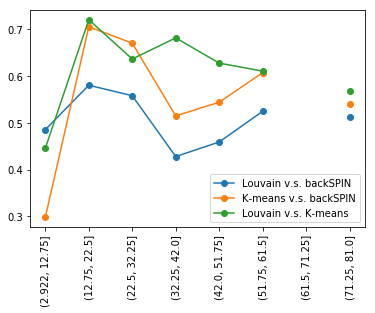

In [93]:
fig, ax = plt.subplots()
ax.plot(res1_list, '-o', label='Louvain v.s. backSPIN')
ax.plot(res2_list, '-o', label='K-means v.s. backSPIN')
ax.plot(res3_list, '-o', label='Louvain v.s. K-means')
ax.set_xticklabels(['foo']+df_info_11.index.tolist(), rotation=90)
ax.legend()
plt.show()

In [138]:
# for i, sub in df_info_pivot.groupby(pd.cut(df_info_pivot.index, 9)):
#     print(sub)
bins = np.arange(0, 75, 10)
pd.cut(df_info_pivot.index, bins)
df_info_11 = df_info_pivot.groupby(pd.cut(df_info_pivot.index, bins)).first()
df_info_11

res1_list = []
res2_list = []
res3_list = []
res11_list = []
res21_list = []
res31_list = []
for bn, row in df_info_11.iterrows():
    try:
        file1 = df_info.loc[(df_info.k == row[('k', 'backspin')]) & (df_info.method=='backspin')].file.values[0]
        file2 = df_info.loc[(df_info.k == row[('k', 'louvain')]) & (df_info.method=='louvain')].file.values[0]
        file3 = df_info.loc[(df_info.k == row[('k', 'kmeans')]) & (df_info.method=='kmeans')].file.values[0]
        df1 = pd.read_table(file1, index_col='sample').sort_index()
        df2 = pd.read_table(file2, index_col='sample').sort_index()
        df3 = pd.read_table(file3, index_col='sample').sort_index()
        
        df1_annot = pd.read_table(file1+'.annot', index_col='cluster_ID')
        df1 = pd.merge(df1, df1_annot, left_on='cluster_ID', right_index=True).sort_index()
        df2_annot = pd.read_table(file2+'.annot', index_col='cluster_ID')
        df2 = pd.merge(df2, df2_annot, left_on='cluster_ID', right_index=True).sort_index()
        df3_annot = pd.read_table(file3+'.annot', index_col='cluster_ID')
        df3 = pd.merge(df3, df3_annot, left_on='cluster_ID', right_index=True).sort_index()
        
        res11 = ars(df1.cluster_annotation, df2.cluster_annotation)
        res21 = ars(df1.cluster_annotation, df3.cluster_annotation)
        res31 = ars(df2.cluster_annotation, df3.cluster_annotation)
        
        res1 = ars(df1.cluster_ID, df2.cluster_ID)
        res2 = ars(df1.cluster_ID, df3.cluster_ID)
        res3 = ars(df2.cluster_ID, df3.cluster_ID)
        
        res1_list.append(res1)
        res2_list.append(res2)
        res3_list.append(res3)
        res11_list.append(res11)
        res21_list.append(res21)
        res31_list.append(res31)
    except:
        res1_list.append(np.nan)
        res2_list.append(np.nan)
        res3_list.append(np.nan)
        res11_list.append(np.nan)
        res21_list.append(np.nan)
        res31_list.append(np.nan)
res11_list

[0.48518816373315071,
 0.81080466343833235,
 0.89060678109042846,
 0.91681920390625582,
 0.90202633771252461,
 0.89768860031386932,
 nan]

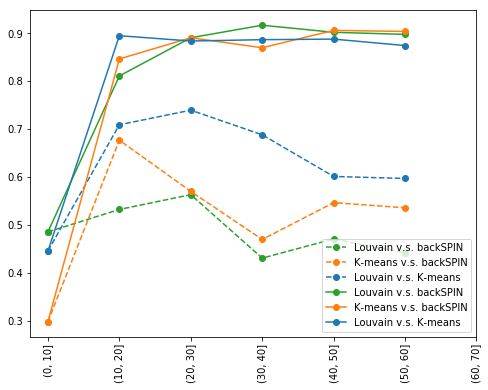

In [139]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(res1_list, '--o', label='Louvain v.s. backSPIN', color='C2')
ax.plot(res2_list, '--o', label='K-means v.s. backSPIN', color='C1')
ax.plot(res3_list, '--o', label='Louvain v.s. K-means', color='C0')
ax.plot(res11_list, '-o', label='Louvain v.s. backSPIN', color='C2')
ax.plot(res21_list, '-o', label='K-means v.s. backSPIN', color='C1')
ax.plot(res31_list, '-o', label='Louvain v.s. K-means', color='C0')
ax.set_xticks([i for i in range(len(df_info_11.index.tolist()))])
ax.set_xticklabels(df_info_11.index.tolist(), rotation=90)
ax.legend(loc='lower right')
plt.show()